In [1]:
import gc
import pandas as pd
import scipy.sparse as sps

In [2]:
valid=sps.load_npz("./dressipi_dataset/URM_valid_bought.npz")
bought=valid.indices

In [3]:
dataset=None
dataset_max=None
#["UCF","ICBF","ICF","Graph","TopPop100","TopPop50","TopPop15"]
for file in ["UCF","ICBF","Graph","ICF", "UCF_W","Graph_W","ICF_W", "UCF_WW","ICBF_WW","Graph_WW","ICF_WW"]:
    print(gc.collect())
    print(f"loading {file}")
    df=pd.read_csv(f"./dressipi_top100_candidates/{file}.csv")
    print(len(df))
    print(f"loaded {file}")
    for col in df:
        if "Max" in col:
            df_max=df[["Session_Id",col]].drop_duplicates()
        elif "Score" in col:
            df_feats=df[["Session_Id","Item_ID",col]]
    if dataset is None:
        dataset=df_feats
        dataset_max=df_max
    else:
        dataset=dataset.merge(df_feats,on=["Session_Id","Item_ID"],how="outer")
        dataset_max=dataset_max.merge(df_max,on=["Session_Id"],how="outer")
    del df
        

#del dataset_max
del df_feats
del df_max

72
loading UCF
16643335
loaded UCF
0
loading ICBF
16931962
loaded ICBF
0
loading Graph
9381483
loaded Graph
0
loading ICF
20341641
loaded ICF
0
loading UCF_W
17596954
loaded UCF_W
0
loading Graph_W
9385508
loaded Graph_W
0
loading ICF_W
24747873
loaded ICF_W
0
loading UCF_WW
14999365
loaded UCF_WW
0
loading ICBF_WW
16837163
loaded ICBF_WW
0
loading Graph_WW
9426367
loaded Graph_WW
0
loading ICF_WW
25121935
loaded ICF_WW


In [4]:
import ast
submission_df=pd.read_csv("./candidate-nn/last_month_candidates.csv")
submission_df["score"]=submission_df["score"].map(ast.literal_eval)
submission_df["code"]=submission_df["code"].map(ast.literal_eval)
submission_df["rank"]=submission_df["rank"].map(ast.literal_eval)
submission_df = submission_df.explode(['code','score', 'rank'])
submission_df[["session_id","code","rank"]]=submission_df[["session_id","code","rank"]].astype(int)
submission_df.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_gru","score":"score_gru"},inplace=True)

In [5]:
submission_df.head()

,Session_Id,Item_ID,score_gru,rank_gru
0,918382,3731,0.022378,1
0,918382,2332,0.017789,2
0,918382,2785,0.012271,3
0,918382,1189,0.011465,4
0,918382,4380,0.010622,5


In [6]:
import ast
submission_df_tr=pd.read_csv("./candidate-transformer/last_month_candidates_transformer.csv")
submission_df_tr["score"]=submission_df_tr["score"].map(ast.literal_eval)
submission_df_tr["code"]=submission_df_tr["code"].map(ast.literal_eval)
submission_df_tr["rank"]=submission_df_tr["rank"].map(ast.literal_eval)
submission_df_tr = submission_df_tr.explode(['code','score', 'rank'])
submission_df_tr[["session_id","code","rank"]]=submission_df_tr[["session_id","code","rank"]].astype(int)
submission_df_tr.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_transformer","score":"score_transformer"},inplace=True)

In [7]:
import ast
submission_df_LSTM=pd.read_csv("candidate-lstm/last_month_candidates_lstm_bidirectional.csv")
submission_df_LSTM["score"]=submission_df_LSTM["score"].map(ast.literal_eval)
submission_df_LSTM["code"]=submission_df_LSTM["code"].map(ast.literal_eval)
submission_df_LSTM["rank"]=submission_df_LSTM["rank"].map(ast.literal_eval)
submission_df_LSTM = submission_df_LSTM.explode(['code','score', 'rank'])
submission_df_LSTM[["session_id","code","rank"]]=submission_df_LSTM[["session_id","code","rank"]].astype(int)
submission_df_LSTM.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_LSTM","score":"score_LSTM"},inplace=True)

In [8]:
dataset=dataset.merge(submission_df,on=["Session_Id","Item_ID"],how="outer")
dataset=dataset.merge(submission_df_tr,on=["Session_Id","Item_ID"],how="outer")
dataset=dataset.merge(submission_df_LSTM,on=["Session_Id","Item_ID"],how="outer")

dataset=dataset.merge(dataset_max,on=["Session_Id"],how="left")


In [9]:
del dataset_max
del submission_df
del submission_df_tr

In [10]:
import numpy as np
sessions=np.unique(dataset["Session_Id"])
train=pd.DataFrame()
train["Session_Id"]=sessions
train["Item_ID"]=bought
train["target"]=1

In [11]:
gc.collect()

2739

In [12]:
dataset=dataset.merge(train,on=["Session_Id","Item_ID"],how="left")
dataset.fillna(0,inplace=True)
gc.collect()

0

In [13]:
dataset["target"]=dataset["target"].astype("int8")
gc.collect()

0

In [14]:
dataset

,Session_Id,Item_ID,Score_UCF,Score_ICBF,Score_Graph,Score_ICF,Score_UCF_W,Score_Graph_W,Score_ICF_W,Score_UCF_WW,...,Max_Score_Graph,Max_Score_ICF,Max_Score_UCF_W,Max_Score_Graph_W,Max_Score_ICF_W,Max_Score_UCF_WW,Max_Score_ICBF_WW,Max_Score_Graph_WW,Max_Score_ICF_WW,target
0,918382,36,0.063570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.982604,0.395666,67.91601,19.691810,3.099367,42.903336,11.467654,5.222927,0.943502,0
1,918382,42,0.082443,0.000000,0.000000,0.000000,0.080240,0.000000,0.000000,0.000000,...,1.982604,0.395666,67.91601,19.691810,3.099367,42.903336,11.467654,5.222927,0.943502,0
2,918382,78,0.573479,0.000000,0.377850,0.587459,0.621391,0.114901,0.166358,0.401511,...,1.982604,0.395666,67.91601,19.691810,3.099367,42.903336,11.467654,5.222927,0.943502,0
3,918382,103,0.104188,0.008208,0.000000,0.027119,0.121782,0.000000,0.004712,0.000000,...,1.982604,0.395666,67.91601,19.691810,3.099367,42.903336,11.467654,5.222927,0.943502,0
4,918382,178,0.338673,0.000000,0.142546,0.412063,0.312842,0.052162,0.104706,0.224624,...,1.982604,0.395666,67.91601,19.691810,3.099367,42.903336,11.467654,5.222927,0.943502,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56941501,999999,829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.826448,0.786831,60.00573,12.597983,0.726854,62.420902,5.397147,9.594196,0.481122,0
56941502,999999,1535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.826448,0.786831,60.00573,12.597983,0.726854,62.420902,5.397147,9.594196,0.481122,0
56941503,999999,4184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.826448,0.786831,60.00573,12.597983,0.726854,62.420902,5.397147,9.594196,0.481122,0
56941504,999999,3252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.826448,0.786831,60.00573,12.597983,0.726854,62.420902,5.397147,9.594196,0.481122,0


In [15]:
sessions_containing_bought_among_candidates=dataset[["Session_Id","target"]].groupby("Session_Id").agg(sum).reset_index()
sessions_containing_bought_among_candidates=sessions_containing_bought_among_candidates.loc[sessions_containing_bought_among_candidates["target"]>0]

dataset=dataset[dataset['Session_Id'].isin(sessions_containing_bought_among_candidates["Session_Id"].tolist())]

In [ ]:
NHITS=len(dataset['Session_Id'].unique())
HITRATE=NHITS/81600 #approximate value 
HITRATE

In [16]:
dataset.head(20)

,Session_Id,Item_ID,Score_UCF,Score_ICBF,Score_Graph,Score_ICF,Score_UCF_W,Score_Graph_W,Score_ICF_W,Score_UCF_WW,...,Max_Score_Graph,Max_Score_ICF,Max_Score_UCF_W,Max_Score_Graph_W,Max_Score_ICF_W,Max_Score_UCF_WW,Max_Score_ICBF_WW,Max_Score_Graph_WW,Max_Score_ICF_WW,target
179,918383,55,0.051185,0.632362,0.005355,0.018442,0.066431,0.005082,0.019220,0.038009,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0
180,918383,122,0.025237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014329,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0
181,918383,189,0.132228,0.000000,0.020602,0.278846,0.141767,0.020318,0.291440,0.120487,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0
182,918383,215,0.028433,0.000000,0.000000,0.000000,0.053128,0.000000,0.000000,0.021210,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0
183,918383,260,0.035876,0.000000,0.003595,0.012055,0.039421,0.003570,0.009346,0.031059,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0
184,918383,320,0.036859,0.000000,0.000000,0.000000,0.055659,0.000000,0.008957,0.037483,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0
185,918383,357,0.036199,0.000000,0.003286,0.012149,0.033906,0.003091,0.000000,0.031989,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0
186,918383,379,0.036823,0.637329,0.004070,0.016121,0.062934,0.003669,0.017308,0.034027,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0
187,918383,421,0.059025,0.604249,0.013832,0.319644,0.026181,0.013433,0.326222,0.041415,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0
188,918383,506,0.029604,0.493767,0.003990,0.017444,0.000000,0.003703,0.011914,0.000000,...,91.79825,1.092114,333.63797,95.052956,1.043109,509.9962,4.748597,68.010704,0.618097,0


In [17]:
dataset_macro_features = pd.read_csv('./macro-feats/train_with_macro_feats.csv',
                                     usecols=['session_id',
                                                'session_similarity',
                                                'session_similarity_uniques', 'session_similarity_feats', 'session_similarity_feats_uniques',
                                              'length_of_session_seconds',
                   'avg_time_spent_per_item_seconds',
                   'variance_time_spent_per_item_seconds',
                   'n_seen_items',
                   'n_unique_items',])

dataset_macro_features.rename(columns={'session_id':'Session_Id'}, inplace=True)
dataset = dataset.merge(dataset_macro_features, on='Session_Id', how='left')
del dataset_macro_features

In [18]:
from sklearn.model_selection import KFold
import lightgbm
import os
k=10
try:
    os.mkdir(f"./{k}_fold_fixed_candidates_weight_decay_weight_decay_session")
except:
    pass

score=0
kf = KFold(n_splits=k)
index=0
for train_index, valid_index in kf.split(train):

    train_sessions=train["Session_Id"][train_index].tolist()
    valid_sessions=train["Session_Id"][valid_index].tolist()

    train_set=dataset[dataset["Session_Id"].isin(train_sessions)]
    valid_set=dataset[dataset["Session_Id"].isin(valid_sessions)]

    train_set=train_set.sort_values("Session_Id")
    valid_set=valid_set.sort_values("Session_Id")
    
    qids_train = train_set[["Session_Id"]].groupby("Session_Id")["Session_Id"].count().to_numpy()
    qids_valid = valid_set[["Session_Id"]].groupby("Session_Id")["Session_Id"].count().to_numpy()
    
    X_train=train_set.drop(["target","Session_Id","Item_ID"],axis=1)
    y_train=train_set["target"]
    
    X_valid=valid_set.drop(["target","Session_Id","Item_ID"],axis=1)
    y_valid=valid_set["target"]

    model = lightgbm.LGBMRanker(
    objective="lambdarank",
    #objective="rank_xendcg",
    #metric="mrr",
    n_estimators=2000,
    lambdarank_truncation_level=103,
    reg_alpha=1e-4,
    learning_rate=0.05,
    min_child_samples=400,
    subsample=0.8,
    subsample_freq=20
    )
    ranker=model.fit(
        X=X_train,
        y=y_train,
        group=qids_train,
        eval_set=[(X_valid, y_valid)],
        eval_group=[qids_valid],
        eval_at=(100),
        callbacks=[lightgbm.log_evaluation(),lightgbm.early_stopping(20,first_metric_only=True)],
        #verbose=10,
        eval_metric=["map","ndcg"]
    )
    ranker.booster_.save_model(f'./{k}_fold_fixed_candidates_weight_decay_weight_decay_session/model_{index}.txt')
    #Get maximum val score
    score+=np.max(ranker._evals_result["valid_0"]["map@100"])
    index+=1

[1]	valid_0's map@100: 0.12248	valid_0's ndcg@100: 0.241877
Training until validation scores don't improve for 20 rounds
[2]	valid_0's map@100: 0.210993	valid_0's ndcg@100: 0.313483
[3]	valid_0's map@100: 0.217046	valid_0's ndcg@100: 0.31841
[4]	valid_0's map@100: 0.216993	valid_0's ndcg@100: 0.318867
[5]	valid_0's map@100: 0.217315	valid_0's ndcg@100: 0.319877
[6]	valid_0's map@100: 0.218867	valid_0's ndcg@100: 0.320913
[7]	valid_0's map@100: 0.21991	valid_0's ndcg@100: 0.321906
[8]	valid_0's map@100: 0.221071	valid_0's ndcg@100: 0.322654
[9]	valid_0's map@100: 0.220978	valid_0's ndcg@100: 0.32286
[10]	valid_0's map@100: 0.221729	valid_0's ndcg@100: 0.3232
[11]	valid_0's map@100: 0.221861	valid_0's ndcg@100: 0.323449
[12]	valid_0's map@100: 0.222399	valid_0's ndcg@100: 0.323817
[13]	valid_0's map@100: 0.222373	valid_0's ndcg@100: 0.323548
[14]	valid_0's map@100: 0.221798	valid_0's ndcg@100: 0.323329
[15]	valid_0's map@100: 0.220966	valid_0's ndcg@100: 0.322571
[16]	valid_0's map@100: 

In [19]:
final_performcance=score/k
print("overall MAP@100 = ", final_performcance)

overall MAP@100 =  0.2462880703847969


In [ ]:
print("normalized score ", final_performcance*HITRATE)

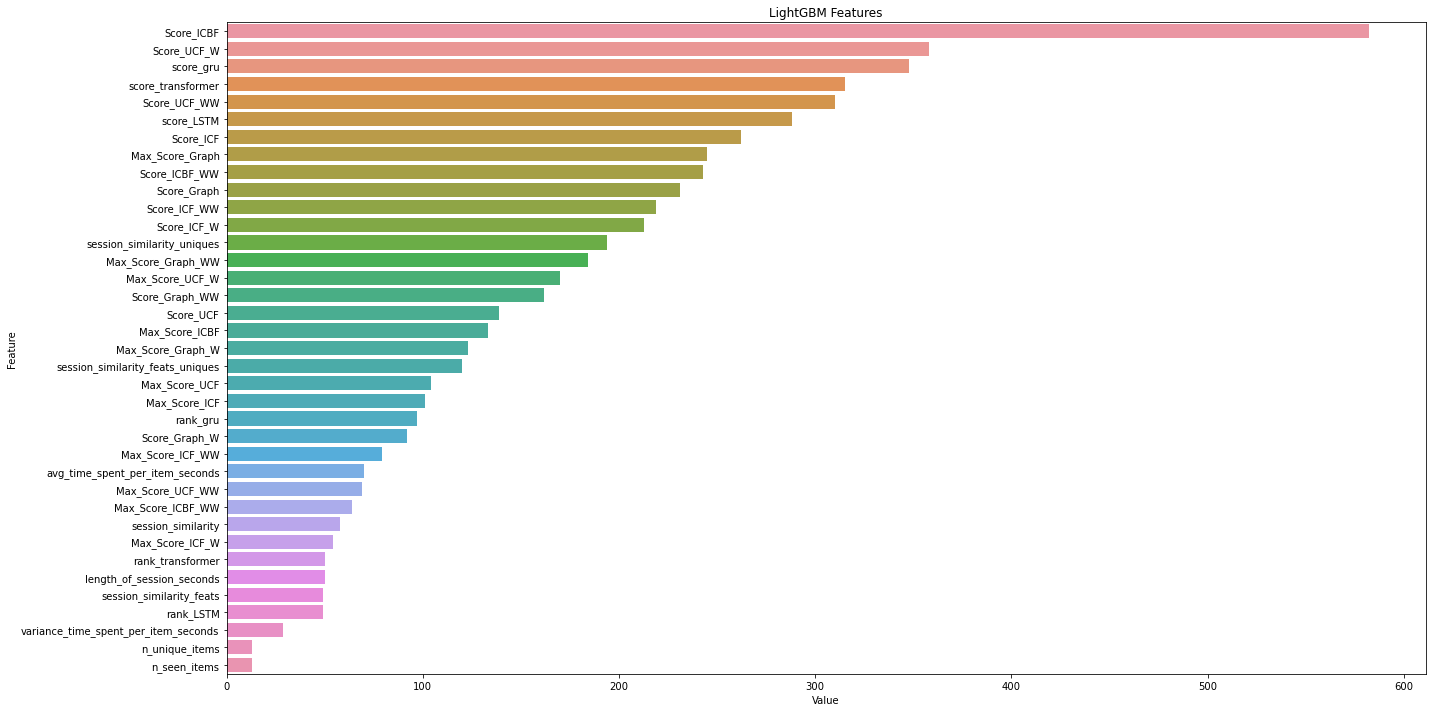

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(ranker.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')